##Bert Model

In [ ]:
!pip install transformers datasets evaluate torch --quiet

In [ ]:
!pip install --upgrade datasets transformers accelerate numpy tokenizers

In [ ]:
import pandas as pd
import numpy as np
import evaluate
import torch
from datasets import Dataset, load_dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
from sklearn.utils import resample
from google.colab import drive
import os
import joblib
from IPython.display import Image, display


In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
print(np.__version__)

2.3.1


In [ ]:
!pip uninstall -y transformers
!pip install transformers==4.40.2

In [ ]:
!pip install numpy==1.24.4

In [ ]:
train = pd.read_csv('drive/MyDrive/ML/Final Project Quora/quora_question_pairs_train.csv.zip', index_col=0)
test = pd.read_csv('drive/MyDrive/ML/Final Project Quora/quora_question_pairs_test.csv.zip', index_col=0)

In [ ]:
train_copy = train.dropna()
test_copy = test.dropna()

#class rebalance
df_majority = train_copy[train_copy.is_duplicate == 0]
df_minority = train_copy[train_copy.is_duplicate == 1]
df_minority_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=42)
train_balanced = pd.concat([df_majority, df_minority_upsampled])

train_df, val_df = train_test_split(train_balanced, test_size=0.1, random_state=42)
test_df = test_copy

In [ ]:
model_path = "google-bert/bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_path)

def preprocess_function(example):
    return tokenizer(
        example['question1'],
        example['question2'],
        truncation=True,
        padding='max_length',
        max_length=128
    )

In [ ]:
#transforn into HuggingFace Dataset
train_dataset = Dataset.from_pandas(train_df[['question1', 'question2', 'is_duplicate']])
val_dataset = Dataset.from_pandas(val_df[['question1', 'question2', 'is_duplicate']])
test_dataset = Dataset.from_pandas(test_df[['question1', 'question2','is_duplicate' ]])

In [ ]:
#data cleaning
train_dataset = train_dataset.remove_columns([col for col in train_dataset.column_names if col not in ['question1', 'question2', 'is_duplicate']])
val_dataset = val_dataset.remove_columns([col for col in val_dataset.column_names if col not in ['question1', 'question2', 'is_duplicate']])
test_dataset = test_dataset.remove_columns([col for col in test_dataset.column_names if col not in ['question1', 'question2', 'is_duplicate']])

In [ ]:
#tokenization
train_dataset = train_dataset.map(preprocess_function, batched=True)
val_dataset = val_dataset.map(preprocess_function, batched=True)
test_dataset = test_dataset.map(preprocess_function, batched=True)

In [ ]:
#Rename target
train_dataset = train_dataset.rename_column("is_duplicate", "labels")
val_dataset = val_dataset.rename_column("is_duplicate", "labels")
test_dataset = test_dataset.rename_column("is_duplicate", "labels")

#Torch format
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

In [ ]:
#unfreeze the higher layer of the model
id2label = {0: "Non-duplicate", 1: "Duplicate"}
label2id = {"Non-duplicate": 0, "Duplicate": 1}

model = AutoModelForSequenceClassification.from_pretrained(
    model_path,
    num_labels=2,
    id2label=id2label,
    label2id=label2id
)


In [ ]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
Tesla T4


In [ ]:
#freeze all the layers
for param in model.base_model.parameters():
    param.requires_grad = False

#unfreeze the encoder layer
for param in model.base_model.encoder.layer[-1].parameters():
    param.requires_grad = True

#unfreeze pooler
for param in model.base_model.pooler.parameters():
    param.requires_grad = True

#classifier
for param in model.classifier.parameters():
    param.requires_grad = True


In [ ]:
#compute metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, zero_division=0),
        "recall": recall_score(labels, preds, zero_division=0),
        "f1": f1_score(labels, preds, zero_division=0),
    }

In [ ]:
#training the model
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/ML/Final Project Quora/bert-checkpoints",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=2,
    load_best_model_at_end=True,
    report_to="none",
    logging_dir="/content/drive/MyDrive/ML/Final Project Quora/logs",
    logging_steps=1000,
)


In [ ]:
print(torch.cuda.is_available())

True


In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()

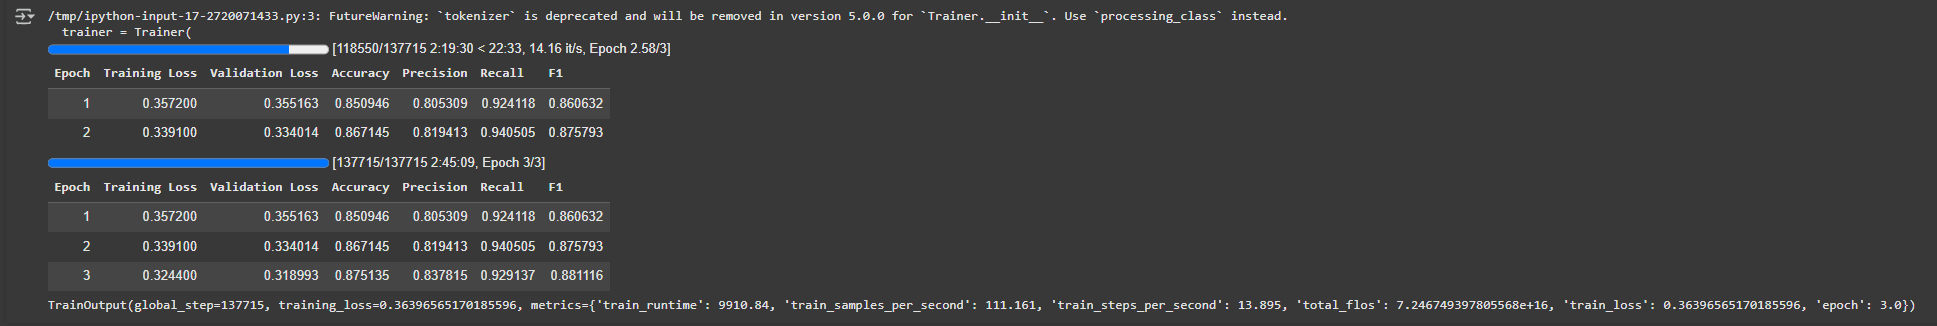

In [ ]:
img_path = "/content/drive/MyDrive/ML/Final Project Quora/bert_training_1.png"
display(Image(img_path))

In [ ]:
trainer.save_model('/content/drive/MyDrive/ML/Final Project Quora/bert-checkpoints')
tokenizer.save_pretrained('/content/drive/MyDrive/ML/Final Project Quora/bert-checkpoints')

('/content/drive/MyDrive/ML/Final Project Quora/bert-checkpoints/tokenizer_config.json',
 '/content/drive/MyDrive/ML/Final Project Quora/bert-checkpoints/special_tokens_map.json',
 '/content/drive/MyDrive/ML/Final Project Quora/bert-checkpoints/vocab.txt',
 '/content/drive/MyDrive/ML/Final Project Quora/bert-checkpoints/added_tokens.json',
 '/content/drive/MyDrive/ML/Final Project Quora/bert-checkpoints/tokenizer.json')

In [ ]:
test_dataset = test_dataset.map(preprocess_function, batched=True)
#Rename target
test_dataset = test_dataset.rename_column("is_duplicate", "labels")
#Torch format
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

In [ ]:
trainer.evaluate(eval_dataset=test_dataset)

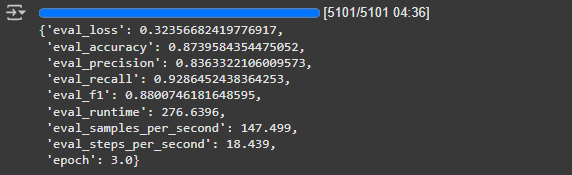

In [ ]:
img_path = "/content/drive/MyDrive/ML/Final Project Quora/bert_test.png"
display(Image(img_path))

In [ ]:
file_path = 'drive/MyDrive/ML/Final Project Quora/model_results.csv'

if not os.path.exists(file_path):
  res.to_csv(file_path, index=False)
else:
  res.to_csv(file_path, mode='a', index=False, header=False)